In [0]:
# imports
import sys
print(sys.version)
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
print(keras.__version__)


import pandas as pd
import numpy as np
import math

import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(0)


3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
1.12.0
2.1.6-tf


In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

   t     noisy     sin_t
0  0  0.090335  0.000000
1  1  0.217882  0.031411
2  2  0.155627  0.062791
3  3  0.041109  0.094108
4  4 -0.012191  0.125333
   var1(t-1)  var2(t-1)   var1(t)   var2(t)
1   0.090335   0.000000  0.217882  0.031411
2   0.217882   0.031411  0.155627  0.062791
3   0.155627   0.062791  0.041109  0.094108
4   0.041109   0.094108 -0.012191  0.125333
5  -0.012191   0.125333  0.374851  0.156434
train  (7500, 4)
test  (2499, 4)
(7500, 1, 3) (7500,) (2499, 1, 3) (2499,)


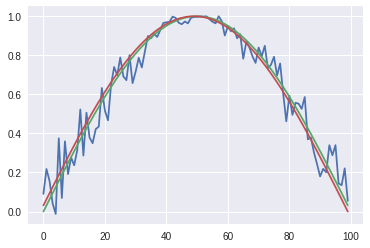

In [0]:
df = pd.DataFrame()
number_of_cycles = 50
steps_per_cycle = 200
random_factor = 0.0
df["t"] = np.arange(number_of_cycles * steps_per_cycle)
df["noisy"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle) + np.random.normal(0,0.1)))
df["sin_t"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)))
print(df.head())

df = df.drop(['t'], axis=1)

agg = series_to_supervised(df)

# agg = agg.drop("var2(t-1)", axis=1)

print(agg.head())
train_len = int(0.75*df.shape[0])
values = agg.values
train = values[:train_len, :]
test = values[train_len:, :]

print("train ", train.shape)
print("test ", test.shape)

# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

plt.plot(x_train[:100,0,0])
plt.plot(x_train[:100,0,1])
plt.plot(y_train[:100])

In [0]:
model = keras.Sequential()
model.add(keras.layers.LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.Dense(10, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
model.save_weights('model.h5')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10800     
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 11,321
Trainable params: 11,321
Non-trainable params: 0
_________________________________________________________________


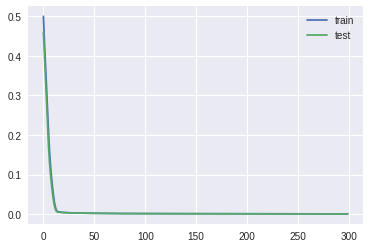

In [0]:
model.load_weights('model.h5')
history = model.fit(x_train, y_train, epochs=300, batch_size=1000, validation_data=(x_test, y_test), verbose=False, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

1.0018299 -1.0003158


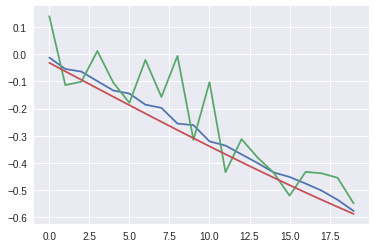

In [0]:
# make a prediction
y_hat = model.predict(x_test)
plt.plot(y_hat[:20])
plt.plot(x_test[:20,0,0])
plt.plot(y_test[:20])

print(np.max(y_hat), np.min(y_hat))

          x         y    x_circ    y_circ
0  0.000000  0.000000  1.000000  0.000000
1  0.006284  0.006284  0.999980  0.006284
2  0.012568  0.012568  0.999921  0.012567
3  0.018851  0.018851  0.999822  0.018850
4  0.025135  0.025135  0.999684  0.025133
    var1(t-20)  var2(t-20)  var3(t-20)  var4(t-20)  var1(t-19)  var2(t-19)  \
20    0.000000    0.000000    1.000000    0.000000    0.006284    0.006284   
21    0.006284    0.006284    0.999980    0.006284    0.012568    0.012568   
22    0.012568    0.012568    0.999921    0.012567    0.018851    0.018851   
23    0.018851    0.018851    0.999822    0.018850    0.025135    0.025135   
24    0.025135    0.025135    0.999684    0.025133    0.031419    0.031419   

    var3(t-19)  var4(t-19)  var1(t-18)  var2(t-18)    ...     var3(t-2)  \
20    0.999980    0.006284    0.012568    0.012568    ...      0.993610   
21    0.999921    0.012567    0.018851    0.018851    ...      0.992881   
22    0.999822    0.018850    0.025135    0.025135    

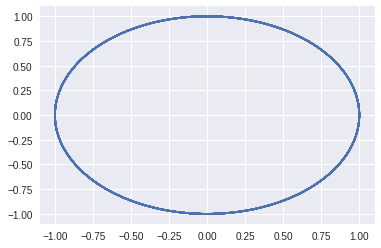

In [0]:
df = pd.DataFrame()
samples=10000
number_of_cycles=10*2*math.pi
random_factor = 0.4

x = np.linspace(0, number_of_cycles, samples)
y = np.linspace(0, number_of_cycles, samples)
x_circ = np.cos(x)
y_circ = np.sin(y)


plt.plot(x_circ, y_circ)
df["x"] = x
df["y"] = y
df["x_circ"] = x_circ
df["y_circ"] = y_circ
print(df.head())

agg = series_to_supervised(df, n_in=20)

# agg["x_circ"] = x_circ[3:]
# agg["y_circ"] = y_circ[3:]


print(agg.head())
train_len = int(0.75*df.shape[0])
values = agg.values
train = values[:train_len, :]
test = values[train_len:, :]

print("train ", train.shape)
print("test ", test.shape)

# split into input and outputs
x_train, y_train = train[:, :-2], train[:, -2:]
x_test, y_test = test[:, :-2], test[:, -2:]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM(70, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.LSTM(50))
model.add(keras.layers.Dense(50, activation='tanh'))
model.add(keras.layers.Dense(2))
model.compile(loss='mse', optimizer='adam')
model.save_weights('model.h5')

model.summary()

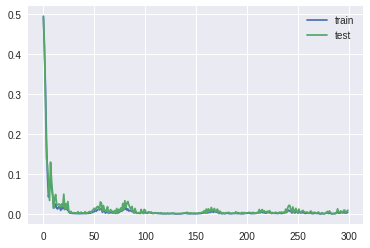

In [0]:
model.load_weights('model.h5')
history = model.fit(x_train, y_train, epochs=300, batch_size=1000, validation_data=(x_test, y_test), verbose=False, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
arr = np.random.rand(10,10)
print(arr.shape)
t = arr[:, -2]
print(t.shape)

(10, 10)
(10,)


    var1(t-20)  var2(t-20)  var3(t-20)  var4(t-20)  var1(t-19)  var2(t-19)  \
20    0.000000    0.000000    0.971470   -0.021776    0.006284    0.006284   
21    0.006284    0.006284    0.943642   -0.017077    0.012568    0.012568   
22    0.012568    0.012568    0.999812    0.006868    0.018851    0.018851   
23    0.018851    0.018851    1.072550   -0.003403    0.025135    0.025135   
24    0.025135    0.025135    1.039207    0.020073    0.031419    0.031419   

    var3(t-19)  var4(t-19)  var1(t-18)  var2(t-18)    ...     var3(t-2)  \
20    0.943642   -0.017077    0.012568    0.012568    ...      1.003974   
21    0.999812    0.006868    0.018851    0.018851    ...      1.001127   
22    1.072550   -0.003403    0.025135    0.025135    ...      0.947362   
23    1.039207    0.020073    0.031419    0.031419    ...      1.006971   
24    1.010709   -0.010830    0.037703    0.037703    ...      0.933074   

    var4(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)  \

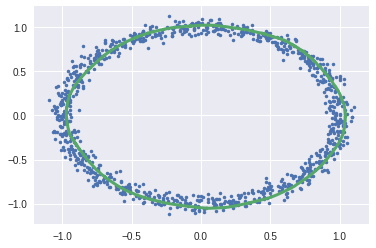

In [0]:
df = pd.DataFrame()

x = np.linspace(0, number_of_cycles, samples)
y = np.linspace(0, number_of_cycles, samples)
df["x"] = x
df["y"] = y
df["x_circ"] = df.x.apply(lambda x: np.cos(x)+np.random.normal(0,0.05))
df["y_circ"] = df.x.apply(lambda x: np.sin(x)+np.random.normal(0,0.05))

agg = series_to_supervised(df, n_in=20)

print(agg.head())
train_len = int(0.1*df.shape[0])
values = agg.values
train = values[:train_len, :]
test = values[train_len:, :]

print("train ", train.shape)
print("test ", test.shape)

# split into input and outputs
x_train, y_train = train[:, :-2], train[:, -2:]
x_test, y_test = test[:, :-2], test[:, -2:]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

                          

y_hat = model.predict(x_test)
plt.plot(y_test[:1000,0], y_test[:1000,1],'.')
plt.plot(y_hat[:1000,0], y_hat[:1000,1], linewidth=3)


In [0]:
"""
z1,z2 = Weighted input
x,y = Input/Output
c = Context/Hidden Layer
a1 = First activation layer
a2 = Second activation layer/ yhat, the estimated output
"""

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_prime(x):
    """Derivative of the sigmoid function."""
    return sigmoid(x)*(1-sigmoid(x))

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu(x):
    return np.maximum(0,x)

def relu_backward(dA, x):
    dZ = np.array(dA, copy = True)
    dZ[x <= 0] = 0;
    return dZ;



#Read and Parse data into y, the input
ya = np.arange(100)
y = np.zeros((len(ya),2))
for i in range(len(ya)):
    y[i] = ya[i]     #Input layer



Loss for epoch 0  is  309077.0668372465
Loss for epoch 1  is  308965.19134740165
Loss for epoch 2  is  308960.45489504695
Loss for epoch 3  is  308957.68320683355
Loss for epoch 4  is  308955.841475565
Loss for epoch 5  is  308954.5211055815
Loss for epoch 6  is  308953.5247940073
Loss for epoch 7  is  308952.7446151616
Loss for epoch 8  is  308952.11621689197
Loss for epoch 9  is  308951.59870538017
Loss for epoch 10  is  308951.1647840043
Loss for epoch 11  is  308950.79550330294
Loss for epoch 12  is  308950.47727958515
Loss for epoch 13  is  308950.2001114602
Loss for epoch 14  is  308949.9564661756
Loss for epoch 15  is  308949.7405586572
Loss for epoch 16  is  308949.5478701816
Loss for epoch 17  is  308949.37481837015
Loss for epoch 18  is  308949.21852561
Loss for epoch 19  is  308949.0766531862
Loss for epoch 20  is  308948.9472802954
Loss for epoch 21  is  308948.8288143517
Loss for epoch 22  is  308948.71992350667
Loss for epoch 23  is  308948.6194852081
Loss for epoch 24  i

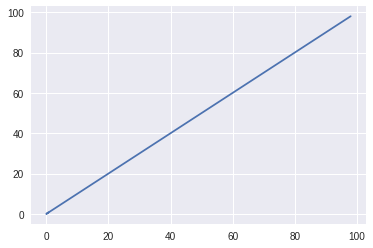

In [0]:
#Build output matrix for prediction    
x = np.roll(y,1,axis=0)
x[0] = [0.65,0.7]        #Output layer

#Input to Hidden weight and bias matrix
w1 = np.random.rand(2,5)

#Context to Hidden weight matrix
w2 = np.random.rand(5,5)
b1 = np.random.rand(1,5)

# Hidden to output weight matrix
w3 = np.random.rand(5,2)
b2 = np.random.rand(1,2)    #Second bias

#Full forward Propagation

c = np.zeros((1,5))
a1 = np.zeros((len(x),5))
z1 = np.zeros((len(x),5))
z2 = np.zeros((len(x),2))
a2 = np.zeros((len(x),2))
mse = np.zeros((len(x),2))
eta = 0.01
delta2 = np.zeros((len(x),2))
delta1 = np.zeros((len(x),5))
e = np.zeros((len(x),2))

for k in range(10000):     #Epochs
    for i in range(len(x)):
        #Input to hidden layer
        z1[i] = np.dot(y[i],w1)+ np.dot(c,w2) + b1  #Weighted Input 1st layer
        a1[i] = sigmoid(z1[i])
        c = a1[i]        #Context layer = Hidden layer
        #Hidden to output layer
        z2[i] = np.dot(c,w3) + b2     #Second Weighted Input values
        a2[i] = sigmoid(z2[i])
        #Mean Squared Error
        e[i] = np.subtract(a2[i], x[i])
        mse[i] = 0.5*np.square(e[i])
        
        #BackProp   
        delta2[i] = e[i] * sigmoid_prime(z2[i])   # [1*2]
        delta1[i] = np.dot(delta2[i], w3.T) * sigmoid_prime(z1[i])   #[1*5]
        
    for j in reversed(range(len(x)-1)):
        delta1[j] += sigmoid_prime(z1[j+1])* np.dot(delta1[j+1],w2.T)   #[1*5]  
    
    w3 -= (eta/2)*(np.dot(a1.T,delta2))     #[5*2]
    w2 -= (eta/2)*(np.dot(a1.T,delta1))     #[5*5]
    w1 -= (eta/2)*(np.dot(x.T,delta1))      #[2*5]
    
    b2 -= (eta/2) * np.sum(delta2,axis = 0)
    b1 -= (eta/2) * np.sum(delta1, axis = 0)
    print('Loss for epoch '+str(k)+ '  is  ' +str(np.sum(mse)))
    
plt.plot(x[:,0], x[:,1])
plt.plot(a2[:,0], a2[:,1])